# Predicting number of subscription

In this notebook, SBB data with different features realated to Zones is taken to predict the Sale of SBB subscriptions. 

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import tensorflow as tf

In [2]:
import sklearn
from sklearn import linear_model
from scipy.io import mmread
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

#### Reading the data

The structure data is in an excel workbook with 3 sheets

- The first sheet has all the features describing a zone. 
- The second sheet has information on Swiss Municapilities.
- The thirt shhet has  information on Swiss Municapilities.

The data is read into pandas and merged into a single data frame with all the features.

In [3]:
df_excel   = pd.read_excel("data/1100_2017-Strukturdaten_Data_D_F_v1.1.0.xlsx", header=1, skiprows=1)
df_msrid   = pd.read_excel("data/1100_2017-Strukturdaten_Data_D_F_v1.1.0.xlsx", header=1, skiprows=0, sheet_name=2)
df_cantid  = pd.read_excel("data/1100_2017-Strukturdaten_Data_D_F_v1.1.0.xlsx", header=1, skiprows=0, sheet_name=3)

In [4]:
# Merge msrname and cantname in main DF
df_strukturdaten = df_excel
df_strukturdaten = df_strukturdaten.merge(df_msrid, left_on='msrid'  , right_on='Code').drop(columns=['Code']).rename(columns={"Label": "Municipality"})
df_strukturdaten = df_strukturdaten.merge(df_cantid, left_on='cantid', right_on='Code').drop(columns=['Code']).rename(columns={"Label": "Canton"})
#filtering out 'X' records, dataframe has X where column r has X.
df_strukturdaten = df_strukturdaten[df_strukturdaten.r != 'X']

Since the target is to pridict the Sale of SBB subscription given various features in a zone, lets collect all SBB subscription purchased in a zone. There are 3 types of SBB subscriptions purchased in any zone

1. Half Fare card subscriptions
2. GA or General Abonoment
3. Reagional and other passes

The total subscription sold will be the sum of all 3 subscription types. A new feature for total subscription is added to the data frame which may be taken as target for out prodictors along with other subscription types.

In [5]:
# find total SBB Subscriptions
# sum Halbtax + GA + other
column_names = ['R_HT','R_GATC','R_LTC']
df_strukturdaten['subs_total']= df_strukturdaten[column_names].sum(axis=1)

### Data Cleansing

SBB data set has wierd convoluted names. Lets rename some of the fields to more human readable titles.

In [6]:
#renaming columns
# As they would appear in order in the final dataframe, top to down
#   old name                 ->  new name
cols = {
    'npvmid'                   : "Zone Id",
    'stg_type'                 : "Zone_Type",
    'munid'                    : "Municipality_Id",
    'Municipality'             : "Municipality_Name",
    'msrid'                    : "Gemeinde_Id",
    'N_Gem'                    : "Gemeinde_Name",
    'cantid'                   : "Canton_Id",
    'Canton'                   : "Canton_Name",
    # Inhibitant Numbers
    "r"                        : "Number_Of_Inhabitants",
    "r_age"                    : "Inhabitant_Average_Age",
    'R_MALEP'                  : "Number_Of_Inhabitants_Male",
    'R_FEMALEP'                : "Number_Of_Inhabitants_FeMale",
    "R_06_24"                  : "Number_Of_Inhabitants_Aged_06-24",
    "R_18_44"                  : "Number_Of_Inhabitants_Aged_18-44",
    'R_INCOME'                 : "Inhabitant_Average_Income",
    # Travel                   
    'R_CARAVBL'                : "Number_Of_Inhabitants_With_Car",
    'R_CAROWNER'               : "Number_Of_Inhabitants_With_Own_Car",
    'R_COMPANYCAR'             : "Number_Of_Inhabitants_With_Company_Car",
    'subs_total'               : "Number_Of_Inhabitants_With_SBB_Abo",
    'R_HT'                     : "Number_Of_Inhabitants_With_SBB_HalbTax",
    'R_GATC'                   : "Number_Of_Inhabitants_With_SBB_GA",
    'R_LTC'                    : "Number_Of_Inhabitants_With_SBB_Regional_Abo",
    # Segments                 
    'R_0017_CARNOTC'           : "Inhabitants_Under_17_With_Car_No_Abo",
    'R_1824_CARNOTC'           : "Inhabitants_18-24_With_Car_No_Abo",
    'R_2544_CARNOTC'           : "Inhabitants_25-44_With_Car_No_Abo",
    'R_4564_CARNOTC'           : "Inhabitants_45-64_With_Car_No_Abo",
    'R_6574_CARNOTC'           : "Inhabitants_65-74_With_Car_No_Abo",
    'R_75XX_CARNOTC'           : "Inhabitants_Over_75_With_Car_No_Abo",
    'R_0017_CARTC'             : "Inhabitants_Under_17_With_Car_And_Abo",
    'R_1824_CARTC'             : "Inhabitants_18-24_With_Car_And_Abo",
    'R_2544_CARTC'             : "Inhabitants_25-44_With_Car_And_Abo",
    'R_4564_CARTC'             : "Inhabitants_45-64_With_Car_And_Abo",
    'R_6574_CARTC'             : "Inhabitants_65-74_With_Car_And_Abo",
    'R_75XX_CARTC'             : "Inhabitants_Over_75_With_Car_And_Abo",
    'R_0017_NOCNOTC'           : "Inhabitants_Under_17_No_Car_No_Abo",
    'R_1824_NOCNOTC'           : "Inhabitants_18-24_No_Car_No_Abo",
    'R_2544_NOCNOTC'           : "Inhabitants_25-44_No_Car_No_Abo",
    'R_4564_NOCNOTC'           : "Inhabitants_45-64_No_Car_No_Abo",
    'R_6574_NOCNOTC'           : "Inhabitants_65-74_No_Car_No_Abo",
    'R_75XX_NOCNOTC'           : "Inhabitants_Over_75_No_Car_No_Abo",
    'R_0017_NOCTC'             : "Inhabitants_Under_17_No_Car_With_Abo",
    'R_1824_NOCTC'             : "Inhabitants_18-24_No_Car_With_Abo",
    'R_2544_NOCTC'             : "Inhabitants_25-44_No_Car_With_Abo",
    'R_4564_NOCTC'             : "Inhabitants_45-64_No_Car_With_Abo",
    'R_6574_NOCTC'             : "Inhabitants_65-74_No_Car_With_Abo",
    'R_75XX_NOCTC'             : "Inhabitants_Over_75_No_Car_With_Abo",
    # Employeed Numbers        
    "re"                       : "Number_Of_Employees",
    "sum_e"                    : "Number_Of_Jobs",
    'e_a'                      : "Number_Of_Trainee_Jobs",
    'e_e'                      : "Number_Of_Non_Skill_Jobs",
    'e_m'                      : "Number_Of_Skill_Jobs",
    'e_cb'                     : "Number_Of_Cross_Border_Jobs",
    'fte_e'                    : "Number_Of_Non_Skill_employements",
    'fte_m'                    : "Number_Of_Skill_employements",
    'fte_cb'                   : "Number_Of_Cross_Border_employements",
    # Student                  
    "R_pupils"                 : "Number_Of_Schoolers",
    "pupils_I"                 : "Number_Of_Primary_Schoolers",
    "pupils_II"                : "Number_Of_Secondary_Schoolers",
    "pupils_II"                : "Number_Of_Secondary_Schoolers",
    "R_pupils_CAR"             : "Number_Of_Pupils_With_Car",
    "R_pupils_NOCTC"           : "Number_Of_Pupils_NoCar_But_SBB_Abo",
    "R_pupils_NOCNOTC"         : "Number_Of_Pupils_NoCar_And_No_SBB_Abo",
    "R_students"               : "Number_Of_Students",
    "R_students_CAR"           : "Number_Of_Students_With_Car",
    "R_students_NOC"           : "Number_Of_Students_Without_Car",
    # Visitors
    'VISITORS_sales'           : 'Daily_Shopping_Visits',
    'VISITORS_sales_st'        : 'Daily_Shopping_Visits_Short',
    'VISITORS_sales_lt'        : 'Daily_Shopping_Visits_Long',
    'DWVplus'                  : 'Daily_Staduim_Visits',
    'VISITORS_NatureReserve'   : 'Daily_Nature_Visits', 
    'VISITORS_Theatre'         : 'Daily_Theatre_Visits',
    'VISITORS_Cinema'          : 'Daily_Cinema_Visits',
    'VISITORS_Library'         : 'Daily_Library_Visits',
    'VISITORS_Museum'          : 'Daily_Museum_Visits',
    'VISITORS_histBuilding'    : 'Daily_Architecture_Visits',
    'VISITORS_Sports'          : 'Daily_Sport_Visits',
    'VISITORS_Fitness'         : 'Daily_Gym_Visits',
    'VISITORS_Gastronomy'      : 'Daily_Restaurant_Visits',
    'VISITORS_Bar_Disco'       : 'Daily_Bar_Disco_Visits',
    'VISITORS_Hotels'          : 'Daily_Hotel_Visits',
    'VISITORS_Hospital'        : 'Daily_Hospital_Visits',
    'VISITORS_Cableway_car'    : 'Daily_Cable_Car_Visits',
    'VISITORS_Leisure'         : 'Daily_Leisure_Visits',
    # not doing everything
    'RE_0017_CARNOTC'          : 'RE_0017_CARNOTC'     ,
    'RE_1824_CARNOTC'          : 'RE_1824_CARNOTC'     ,
    'RE_2544_CARNOTC'          : 'RE_2544_CARNOTC'     ,
    'RE_4564_CARNOTC'          : 'RE_4564_CARNOTC'     ,
    'RE_6574_CARNOTC'          : 'RE_6574_CARNOTC'     ,
    'RE_75XX_CARNOTC'          : 'RE_75XX_CARNOTC'     ,
    'RE_0017_CARTC'            : 'RE_0017_CARTC'       ,
    'RE_1824_CARTC'            : 'RE_1824_CARTC'       ,
    'RE_2544_CARTC'            : 'RE_2544_CARTC'       ,
    'RE_4564_CARTC'            : 'RE_4564_CARTC'       ,
    'RE_6574_CARTC'            : 'RE_6574_CARTC'       ,
    'RE_75XX_CARTC'            : 'RE_75XX_CARTC'       ,
    'RE_0017_NOCNOTC'          : 'RE_0017_NOCNOTC'     ,
    'RE_1824_NOCNOTC'          : 'RE_1824_NOCNOTC'     ,
    'RE_2544_NOCNOTC'          : 'RE_2544_NOCNOTC'     ,
    'RE_4564_NOCNOTC'          : 'RE_4564_NOCNOTC'     ,
    'RE_6574_NOCNOTC'          : 'RE_6574_NOCNOTC'     ,
    'RE_75XX_NOCNOTC'          : 'RE_75XX_NOCNOTC'     ,
    'RE_0017_NOCTC'            : 'RE_0017_NOCTC'       ,
    'RE_1824_NOCTC'            : 'RE_1824_NOCTC'       ,
    'RE_2544_NOCTC'            : 'RE_2544_NOCTC'       ,
    'RE_4564_NOCTC'            : 'RE_4564_NOCTC'       ,
    'RE_6574_NOCTC'            : 'RE_6574_NOCTC'       ,
    'RE_75XX_NOCTC'            : 'RE_75XX_NOCTC'       ,
    'RE_E_0017_CARNOTC'        : 'RE_E_0017_CARNOTC'   ,
    'RE_E_1824_CARNOTC'        : 'RE_E_1824_CARNOTC'   ,
    'RE_E_2544_CARNOTC'        : 'RE_E_2544_CARNOTC'   ,
    'RE_E_4564_CARNOTC'        : 'RE_E_4564_CARNOTC'   ,
    'RE_E_6574_CARNOTC'        : 'RE_E_6574_CARNOTC'   ,
    'RE_E_75XX_CARNOTC'        : 'RE_E_75XX_CARNOTC'   ,
    'RE_E_0017_CARTC'          : 'RE_E_0017_CARTC'     ,
    'RE_E_1824_CARTC'          : 'RE_E_1824_CARTC'     ,
    'RE_E_2544_CARTC'          : 'RE_E_2544_CARTC'     ,
    'RE_E_4564_CARTC'          : 'RE_E_4564_CARTC'     ,
    'RE_E_6574_CARTC'          : 'RE_E_6574_CARTC'     ,
    'RE_E_75XX_CARTC'          : 'RE_E_75XX_CARTC'     ,
    'RE_E_0017_NOCNOTC'        : 'RE_E_0017_NOCNOTC'   ,
    'RE_E_1824_NOCNOTC'        : 'RE_E_1824_NOCNOTC'   ,
    'RE_E_2544_NOCNOTC'        : 'RE_E_2544_NOCNOTC'   ,
    'RE_E_4564_NOCNOTC'        : 'RE_E_4564_NOCNOTC'   ,
    'RE_E_6574_NOCNOTC'        : 'RE_E_6574_NOCNOTC'   ,
    'RE_E_75XX_NOCNOTC'        : 'RE_E_75XX_NOCNOTC'   ,
    'RE_E_0017_NOCTC'          : 'RE_E_0017_NOCTC'     ,
    'RE_E_1824_NOCTC'          : 'RE_E_1824_NOCTC'     ,
    'RE_E_2544_NOCTC'          : 'RE_E_2544_NOCTC'     ,
    'RE_E_4564_NOCTC'          : 'RE_E_4564_NOCTC'     ,
    'RE_E_6574_NOCTC'          : 'RE_E_6574_NOCTC'     ,
    'RE_E_75XX_NOCTC'          : 'RE_E_75XX_NOCTC'     ,
    'RE_M_0017_CARNOTC'        : 'RE_M_0017_CARNOTC'   ,
    'RE_M_1824_CARNOTC'        : 'RE_M_1824_CARNOTC'   ,
    'RE_M_2544_CARNOTC'        : 'RE_M_2544_CARNOTC'   ,
    'RE_M_4564_CARNOTC'        : 'RE_M_4564_CARNOTC'   ,
    'RE_M_6574_CARNOTC'        : 'RE_M_6574_CARNOTC'   ,
    'RE_M_75XX_CARNOTC'        : 'RE_M_75XX_CARNOTC'   ,
    'RE_M_0017_CARTC'          : 'RE_M_0017_CARTC'     ,
    'RE_M_1824_CARTC'          : 'RE_M_1824_CARTC'     ,
    'RE_M_2544_CARTC'          : 'RE_M_2544_CARTC'     ,
    'RE_M_4564_CARTC'          : 'RE_M_4564_CARTC'     ,
    'RE_M_6574_CARTC'          : 'RE_M_6574_CARTC'     ,
    'RE_M_75XX_CARTC'          : 'RE_M_75XX_CARTC'     ,
    'RE_M_0017_NOCNOTC'        : 'RE_M_0017_NOCNOTC'   ,
    'RE_M_1824_NOCNOTC'        : 'RE_M_1824_NOCNOTC'   ,
    'RE_M_2544_NOCNOTC'        : 'RE_M_2544_NOCNOTC'   ,
    'RE_M_4564_NOCNOTC'        : 'RE_M_4564_NOCNOTC'   ,
    'RE_M_6574_NOCNOTC'        : 'RE_M_6574_NOCNOTC'   ,
    'RE_M_75XX_NOCNOTC'        : 'RE_M_75XX_NOCNOTC'   ,
    'RE_M_0017_NOCTC'          : 'RE_M_0017_NOCTC'     ,
    'RE_M_1824_NOCTC'          : 'RE_M_1824_NOCTC'     ,
    'RE_M_2544_NOCTC'          : 'RE_M_2544_NOCTC'     ,
    'RE_M_4564_NOCTC'          : 'RE_M_4564_NOCTC'     ,
    'RE_M_6574_NOCTC'          : 'RE_M_6574_NOCTC'     ,
    'RE_M_75XX_NOCTC'          : 'RE_M_75XX_NOCTC'     
}

In [7]:
df_final = df_strukturdaten[cols.keys()].rename(columns=cols)
df_final

,Zone Id,Zone_Type,Municipality_Id,Municipality_Name,Gemeinde_Id,Gemeinde_Name,Canton_Id,Canton_Name,Number_Of_Inhabitants,Inhabitant_Average_Age,...,RE_M_2544_NOCNOTC,RE_M_4564_NOCNOTC,RE_M_6574_NOCNOTC,RE_M_75XX_NOCNOTC,RE_M_0017_NOCTC,RE_M_1824_NOCTC,RE_M_2544_NOCTC,RE_M_4564_NOCTC,RE_M_6574_NOCTC,RE_M_75XX_NOCTC
0,101001,1,1,Knonaueramt,4,Aeugst am Albis,1,Zürich,1949,43,...,0,0,0,1,0,1,2,7,1,1
1,201001,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1238,40,...,5,7,0,0,0,2,3,2,0,0
2,201002,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,407,49,...,1,0,0,0,0,0,1,1,0,0
3,201003,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1314,44,...,6,11,1,0,0,1,3,3,0,0
4,201004,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1195,44,...,19,10,1,1,0,2,5,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7961,681001001,1,6810,Jura,106,La Baroche,26,Jura,424,42,...,0,1,0,0,0,0,0,0,0,0
7962,681001002,1,6810,Jura,106,La Baroche,26,Jura,152,41,...,0,0,0,0,0,0,0,0,0,0
7963,681001003,1,6810,Jura,106,La Baroche,26,Jura,185,48,...,1,1,0,0,0,0,0,0,0,0
7964,681001004,1,6810,Jura,106,La Baroche,26,Jura,312,46,...,1,1,0,0,0,0,0,0,0,0


### Predictive Modelling

#### Linear regression and random forest will be used here. Also we will remove some redundant features based on feature importance from random forest

In [8]:
df_final.head()

,Zone Id,Zone_Type,Municipality_Id,Municipality_Name,Gemeinde_Id,Gemeinde_Name,Canton_Id,Canton_Name,Number_Of_Inhabitants,Inhabitant_Average_Age,...,RE_M_2544_NOCNOTC,RE_M_4564_NOCNOTC,RE_M_6574_NOCNOTC,RE_M_75XX_NOCNOTC,RE_M_0017_NOCTC,RE_M_1824_NOCTC,RE_M_2544_NOCTC,RE_M_4564_NOCTC,RE_M_6574_NOCTC,RE_M_75XX_NOCTC
0,101001,1,1,Knonaueramt,4,Aeugst am Albis,1,Zürich,1949,43,...,0,0,0,1,0,1,2,7,1,1
1,201001,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1238,40,...,5,7,0,0,0,2,3,2,0,0
2,201002,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,407,49,...,1,0,0,0,0,0,1,1,0,0
3,201003,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1314,44,...,6,11,1,0,0,1,3,3,0,0
4,201004,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1195,44,...,19,10,1,1,0,2,5,3,0,0


Since the 3 different subscription types was aggregated to have one single feature for total number of subscription, lets get rid of the individual subscription types for not and select the total subscriptions as out Target Y. All othet freatures, other than individual subscriptions, would be our selected features for prediction.

In [9]:
df_final = df_final.drop(columns = ['Number_Of_Inhabitants_With_SBB_HalbTax','Number_Of_Inhabitants_With_SBB_GA','Number_Of_Inhabitants_With_SBB_Regional_Abo'])

In [10]:
Y = df_final['Number_Of_Inhabitants_With_SBB_Abo']

In [11]:
Y.describe()

count    7752.000000
mean      517.391254
std       358.621367
min         0.000000
25%       262.000000
50%       454.500000
75%       690.000000
max      4059.000000
Name: Number_Of_Inhabitants_With_SBB_Abo, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x24187860580>,
 'caps': [<matplotlib.lines.Line2D at 0x24187860c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x24187860220>],
 'medians': [<matplotlib.lines.Line2D at 0x24187869340>],
 'fliers': [<matplotlib.lines.Line2D at 0x241878696a0>],
 'means': []}

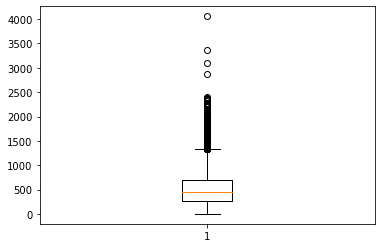

In [12]:
plt.boxplot(Y)

In [13]:
X = df_final.loc[:, df_final.columns != 'Number_Of_Inhabitants_With_SBB_Abo']

At this point we have taken all the available features. We would like to select the best ones which influence and describe the prediction target. this would be done later. To validate the prediction results and select most important features, we need to split the data set into training and test sets. A ratio of 80:20 is used for training vs test data. 

To split the data, a random sample of the 8 percent of training set is taken out. the test set would be the rest of data present in fullt dataset which is not part of the training set

In [14]:
train_x = X.sample(frac=0.8)
test_x = X.loc[~X.index.isin(train_x.index)]

In [15]:
train_y = Y.sample(frac=0.8)
test_y = Y.loc[~Y.index.isin(train_y.index)]

(array([2.744e+03, 2.442e+03, 7.380e+02, 1.920e+02, 6.300e+01, 2.000e+01,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([   0. ,  405.9,  811.8, 1217.7, 1623.6, 2029.5, 2435.4, 2841.3,
        3247.2, 3653.1, 4059. ]),
 <BarContainer object of 10 artists>)

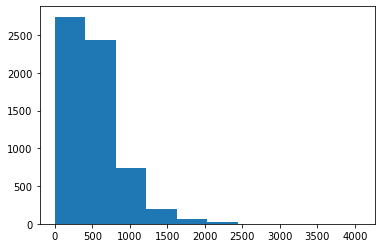

In [16]:
plt.hist(train_y)

In [17]:
corr_matrix = df_final.corr()
corr_matrix['Number_Of_Inhabitants_With_SBB_Abo'].sort_values(ascending=False)

Number_Of_Inhabitants_With_SBB_Abo     1.000000
Number_Of_Primary_Schoolers            0.204649
Number_Of_Skill_Jobs                   0.140012
Number_Of_Skill_employements           0.105299
Number_Of_Secondary_Schoolers          0.088626
Number_Of_Non_Skill_Jobs               0.079856
Number_Of_Jobs                         0.075362
Daily_Restaurant_Visits                0.073279
Number_Of_Trainee_Jobs                 0.064326
Daily_Leisure_Visits                   0.058841
Daily_Library_Visits                   0.045557
Number_Of_Non_Skill_employements       0.040647
Daily_Museum_Visits                    0.025595
Daily_Shopping_Visits_Short            0.025151
Daily_Bar_Disco_Visits                 0.020635
Daily_Sport_Visits                     0.016958
Daily_Theatre_Visits                   0.014341
Daily_Cinema_Visits                    0.011589
Daily_Architecture_Visits              0.011551
Daily_Shopping_Visits                  0.010765
Daily_Hotel_Visits                    -0

In [18]:
# training data with only  features that are highly correlated with "target"
corr_train_x = train_x[[ "Number_Of_Primary_Schoolers", "Number_Of_Secondary_Schoolers", "Number_Of_Skill_Jobs", "Number_Of_Jobs" , "Daily_Restaurant_Visits" , "Daily_Leisure_Visits" , "Daily_Shopping_Visits_Short"]]

In [19]:
corr_train_x

,Number_Of_Primary_Schoolers,Number_Of_Secondary_Schoolers,Number_Of_Skill_Jobs,Number_Of_Jobs,Daily_Restaurant_Visits,Daily_Leisure_Visits,Daily_Shopping_Visits_Short
1099,318,0,116,266,0,3,75
1025,8,0,259,699,347,347,41
726,54,0,115,362,0,1,0
4885,0,0,448,1863,32,32,547
3739,0,0,669,1748,1654,2143,5064
...,...,...,...,...,...,...,...
2969,230,111,319,952,14,59,506
978,14,0,253,576,362,363,16
7075,0,0,391,1567,106,182,1400
1258,99,111,261,471,306,354,599


In [20]:
# training data with all numeric features
numeric_train_x = train_x.drop(['Zone Id','Zone_Type','Municipality_Name','Canton_Name',
                         'Gemeinde_Name','Municipality_Id','Gemeinde_Id','Canton_Id','Inhabitants_Under_17_With_Car_No_Abo','Inhabitants_Under_17_With_Car_And_Abo','Inhabitants_Under_17_No_Car_No_Abo','Inhabitants_Under_17_No_Car_With_Abo','RE_0017_CARNOTC','RE_0017_CARTC',
                                'RE_0017_NOCNOTC','RE_0017_NOCTC','RE_E_0017_CARNOTC','RE_E_0017_CARTC','RE_E_0017_NOCNOTC','RE_E_0017_NOCTC','RE_M_0017_CARNOTC','RE_M_0017_CARTC','RE_M_0017_NOCNOTC','RE_M_0017_NOCTC'], axis=1)

In [21]:
numeric_train_x

,Number_Of_Inhabitants,Inhabitant_Average_Age,Number_Of_Inhabitants_Male,Number_Of_Inhabitants_FeMale,Number_Of_Inhabitants_Aged_06-24,Number_Of_Inhabitants_Aged_18-44,Inhabitant_Average_Income,Number_Of_Inhabitants_With_Car,Number_Of_Inhabitants_With_Own_Car,Number_Of_Inhabitants_With_Company_Car,...,RE_M_1824_NOCNOTC,RE_M_2544_NOCNOTC,RE_M_4564_NOCNOTC,RE_M_6574_NOCNOTC,RE_M_75XX_NOCNOTC,RE_M_1824_NOCTC,RE_M_2544_NOCTC,RE_M_4564_NOCTC,RE_M_6574_NOCTC,RE_M_75XX_NOCTC
1099,2416,41,48,52,500,846,82028,1478,757,243,...,4,23,22,4,2,1,3,1,0,0
1025,1198,36,56,44,207,679,80812,807,230,85,...,1,12,6,1,0,2,10,4,0,0
726,921,46,48,52,141,287,89229,681,484,67,...,0,0,1,0,2,2,2,2,0,0
4885,190,41,51,49,31,61,91309,133,97,9,...,0,0,1,0,0,1,0,1,0,0
3739,1502,40,48,52,246,699,58645,970,433,140,...,1,12,7,0,0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,1450,38,53,47,365,516,79005,1034,745,362,...,0,2,2,0,0,0,1,0,0,0
978,2543,39,49,51,301,1309,74134,1649,576,223,...,0,3,3,0,1,3,38,18,2,0
7075,131,53,43,57,18,26,59704,75,74,5,...,0,0,0,0,0,0,1,3,0,0
1258,1438,44,49,51,245,475,95562,1100,803,32,...,1,2,2,1,21,1,1,1,0,4


In [22]:
cols = list(numeric_train_x.columns)
cols.sort()
cols

['Daily_Architecture_Visits',
 'Daily_Bar_Disco_Visits',
 'Daily_Cable_Car_Visits',
 'Daily_Cinema_Visits',
 'Daily_Gym_Visits',
 'Daily_Hospital_Visits',
 'Daily_Hotel_Visits',
 'Daily_Leisure_Visits',
 'Daily_Library_Visits',
 'Daily_Museum_Visits',
 'Daily_Nature_Visits',
 'Daily_Restaurant_Visits',
 'Daily_Shopping_Visits',
 'Daily_Shopping_Visits_Long',
 'Daily_Shopping_Visits_Short',
 'Daily_Sport_Visits',
 'Daily_Staduim_Visits',
 'Daily_Theatre_Visits',
 'Inhabitant_Average_Age',
 'Inhabitant_Average_Income',
 'Inhabitants_18-24_No_Car_No_Abo',
 'Inhabitants_18-24_No_Car_With_Abo',
 'Inhabitants_18-24_With_Car_And_Abo',
 'Inhabitants_18-24_With_Car_No_Abo',
 'Inhabitants_25-44_No_Car_No_Abo',
 'Inhabitants_25-44_No_Car_With_Abo',
 'Inhabitants_25-44_With_Car_And_Abo',
 'Inhabitants_25-44_With_Car_No_Abo',
 'Inhabitants_45-64_No_Car_No_Abo',
 'Inhabitants_45-64_No_Car_With_Abo',
 'Inhabitants_45-64_With_Car_And_Abo',
 'Inhabitants_45-64_With_Car_No_Abo',
 'Inhabitants_65-74_No_C

#### Training for linear Regression and Random Forest

In [23]:
def train_model(data, label, algo):
    """
    data: training data
    label: response variable
    
    return: fitted model and Root Mean Square Error
    """
    model = algo.fit(data, label)
    return model, np.sqrt(mean_squared_error(label, model.predict(data)))

In [24]:
linear_simple_reg, linear_simple_rmse= train_model(corr_train_x, train_y, LinearRegression())
linear_full_reg, linear_full_rmse= train_model(numeric_train_x, train_y, LinearRegression())
forest_simple_reg, forest_simple_rmse = train_model(corr_train_x, train_y, RandomForestRegressor(random_state=0))
forest_full_reg, forest_full_rmse = train_model(numeric_train_x, train_y, RandomForestRegressor(random_state=0))

In [25]:
print ("Linear regression with highly correlated features RMSE: " + str(linear_simple_rmse))
print ("Linear regression with all numeric features RMSE: " + str(linear_full_rmse))
print ("Random forest with highly correlated features RMSE: " + str(forest_simple_rmse))
print ("Random forest with all numeric features RMSE: " + str(forest_full_rmse))

Linear regression with highly correlated features RMSE: 357.18544021276244
Linear regression with all numeric features RMSE: 354.2399834273412
Random forest with highly correlated features RMSE: 140.6327322525451
Random forest with all numeric features RMSE: 137.58601796970885


In [26]:
from sklearn.metrics import r2_score

In [27]:
model = LinearRegression().fit(numeric_train_x, train_y)
predict = model.predict(numeric_train_x)

r2 = r2_score(train_y, predict)
model.score(numeric_train_x,train_y)
#r2

0.017337615220143876

In [28]:
model1 = RandomForestRegressor().fit(numeric_train_x,train_y)
predict1 = model1.predict(numeric_train_x)
r2 = r2_score(train_y,predict1)
model1.score(numeric_train_x,train_y)

0.8541539865409296

###### We just made predictions using our whole training set and computed RMSE. But this isn't very helpful because the model is tailored for the training data. It's hard to tell whether the model will generalize well on unseen test data.

we can only use test set once, so how do we further check if random forest is truly better? The answer is to use cross validation, especially k-fold cross validation.

K-fold cross validation is to partition the dataset into K random parts. Iterate through each part, training on the rest and testing on that one. Average the performance metric across all iterations for the cross-validation score.

Now let's use a 10-fold cross validation on each of the four models we have trained so far.



In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
def cross_validation_rmse(model, data, label):
    """
    data: training data
    label: response variable
    
    this function performs a 10-fold cross validation and prints out the RMSE scores
    """
    scores = cross_val_score(model, data, label, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    
    print('RMSE from 10-fold cross validation:', rmse_scores)
    print('RMSE Mean:', rmse_scores.mean())
    print('RMSE Standard deviation:', rmse_scores.std())
    

In [31]:
print ("Linear regression with correlated features RMSE: ")
cross_validation_rmse(linear_simple_reg,corr_train_x, train_y)


Linear regression with correlated features RMSE: 
RMSE from 10-fold cross validation: [377.36896694 370.74843601 375.69658277 353.8551593  333.01917522
 369.00169846 330.24331849 333.17958457 352.83355058 375.88803192]
RMSE Mean: 357.18345042647354
RMSE Standard deviation: 18.274572408309535


In [32]:
print ("Linear regression with all numeric features RMSE: ")
cross_validation_rmse(linear_full_reg, numeric_train_x, train_y)

Linear regression with all numeric features RMSE: 
RMSE from 10-fold cross validation: [382.90521549 375.43154237 382.29552299 361.22868381 335.75238364
 372.53294686 333.57349906 338.9940636  361.23765571 378.19446584]
RMSE Mean: 362.21459793674927
RMSE Standard deviation: 18.519012706344437


In [33]:
print ("Random forest with correlated features RMSE: ")
cross_validation_rmse(forest_simple_reg, corr_train_x, train_y)

Random forest with correlated features RMSE: 
RMSE from 10-fold cross validation: [394.62708809 382.76745103 386.48571132 366.99656983 348.63684535
 381.05367532 342.52846531 345.52353239 371.78398041 391.33395623]
RMSE Mean: 371.17372752825787
RMSE Standard deviation: 18.51268552802443


In [34]:
print ("Random forest with with all numeric fueatures RMSE: ")
cross_validation_rmse(forest_full_reg, numeric_train_x, train_y)

Random forest with with all numeric fueatures RMSE: 
RMSE from 10-fold cross validation: [382.34328131 374.69739147 384.25723679 356.28151422 348.82563835
 376.38653848 345.07751262 346.61111018 363.34513205 386.23171278]
RMSE Mean: 366.40570682515136
RMSE Standard deviation: 15.497632320834548


From results, we can see the RMSE is higher than what we got previously. This makes sense because in k-fold cross validation each fold is treated as if it was a unseen test set so we can avoid over fitting. It should be noted that, when the dataset is really large, k-fold validation can be very slow. 10-fold validation means we train the model 10 times. 


#### Feature Importance Analysis

For ensemble methods such as random forest, we can extract feature importance. It helps us visualize which features are more predictive. Then we might be able to remove some redundant features without harming the model performance much.

In [35]:
full_num_features = ['Number_Of_Inhabitants', 'Inhabitant_Average_Age', 'Number_Of_Inhabitants_Male',
                     'Number_Of_Inhabitants_FeMale', 'Number_Of_Inhabitants_Aged_06-24', 'Number_Of_Inhabitants_Aged_18-44',
                     'Inhabitant_Average_Income', 
                     'Number_Of_Inhabitants_With_Car','Number_Of_Inhabitants_With_Own_Car', 'Number_Of_Inhabitants_With_Company_Car', 
                     'Inhabitants_18-24_With_Car_No_Abo','Inhabitants_25-44_With_Car_No_Abo', 'Inhabitants_45-64_With_Car_No_Abo', 
                     'Inhabitants_65-74_With_Car_No_Abo','Inhabitants_Over_75_With_Car_No_Abo',
                     'Inhabitants_18-24_With_Car_And_Abo','Inhabitants_25-44_With_Car_And_Abo','Inhabitants_45-64_With_Car_And_Abo',
                     'Inhabitants_65-74_With_Car_And_Abo','Inhabitants_Over_75_With_Car_And_Abo',
                     'Inhabitants_18-24_No_Car_No_Abo','Inhabitants_25-44_No_Car_No_Abo','Inhabitants_45-64_No_Car_No_Abo',
                     'Inhabitants_65-74_No_Car_No_Abo','Inhabitants_Over_75_No_Car_No_Abo',
                     'Inhabitants_18-24_No_Car_With_Abo','Inhabitants_25-44_No_Car_With_Abo','Inhabitants_45-64_No_Car_With_Abo',
                     'Inhabitants_65-74_No_Car_With_Abo','Inhabitants_Over_75_No_Car_With_Abo',
                     'Number_Of_Employees','Number_Of_Jobs','Number_Of_Trainee_Jobs',
                     'Number_Of_Non_Skill_Jobs','Number_Of_Skill_Jobs','Number_Of_Cross_Border_Jobs','Number_Of_Non_Skill_employements',
                     'Number_Of_Skill_employements','Number_Of_Cross_Border_employements','Number_Of_Schoolers','Number_Of_Primary_Schoolers',
                     'Number_Of_Secondary_Schoolers','Number_Of_Pupils_With_Car',
                     'Number_Of_Pupils_NoCar_But_SBB_Abo','Number_Of_Pupils_NoCar_And_No_SBB_Abo','Number_Of_Students',
                     'Number_Of_Students_With_Car','Number_Of_Students_Without_Car','Daily_Shopping_Visits',
                     'Daily_Shopping_Visits_Short','Daily_Shopping_Visits_Long','Daily_Staduim_Visits','Daily_Nature_Visits',
                     'Daily_Theatre_Visits','Daily_Cinema_Visits','Daily_Library_Visits','Daily_Museum_Visits',
                     'Daily_Architecture_Visits','Daily_Sport_Visits','Daily_Gym_Visits','Daily_Restaurant_Visits',
                     'Daily_Bar_Disco_Visits','Daily_Hotel_Visits','Daily_Hospital_Visits','Daily_Cable_Car_Visits',
                     'Daily_Leisure_Visits','RE_1824_CARNOTC','RE_2544_CARNOTC','RE_4564_CARNOTC','RE_6574_CARNOTC',
                     'RE_75XX_CARNOTC','RE_1824_CARTC','RE_2544_CARTC','RE_4564_CARTC','RE_6574_CARTC','RE_75XX_CARTC',
                     'RE_1824_NOCNOTC','RE_2544_NOCNOTC','RE_4564_NOCNOTC','RE_6574_NOCNOTC','RE_75XX_NOCNOTC','RE_1824_NOCTC',
                     'RE_2544_NOCTC','RE_4564_NOCTC','RE_6574_NOCTC','RE_75XX_NOCTC','RE_E_1824_CARNOTC','RE_E_2544_CARNOTC',
                     'RE_E_4564_CARNOTC','RE_E_6574_CARNOTC','RE_E_75XX_CARNOTC','RE_E_1824_CARTC','RE_E_2544_CARTC',
                     'RE_E_4564_CARTC','RE_E_6574_CARTC','RE_E_75XX_CARTC','RE_E_1824_NOCNOTC','RE_E_2544_NOCNOTC',
                     'RE_E_4564_NOCNOTC','RE_E_6574_NOCNOTC','RE_E_75XX_NOCNOTC','RE_E_1824_NOCTC','RE_E_2544_NOCTC',
                     'RE_E_4564_NOCTC','RE_E_6574_NOCTC','RE_E_75XX_NOCTC','RE_M_1824_CARNOTC','RE_M_2544_CARNOTC',
                     'RE_M_4564_CARNOTC','RE_M_6574_CARNOTC','RE_M_75XX_CARNOTC','RE_M_1824_CARTC','RE_M_2544_CARTC',
                     'RE_M_4564_CARTC','RE_M_6574_CARTC','RE_M_75XX_CARTC','RE_M_1824_NOCNOTC','RE_M_2544_NOCNOTC',
                     'RE_M_4564_NOCNOTC','RE_M_6574_NOCNOTC','RE_M_75XX_NOCNOTC','RE_M_1824_NOCTC','RE_M_2544_NOCTC',
                     'RE_M_4564_NOCTC','RE_M_6574_NOCTC','RE_M_75XX_NOCTC'            
                    ]

In [36]:
def feature_importance_plot(importance_list, col_list):
    """
    importance_list: a list of feature importance
    col_list: a list of column names matching the importance list
    
    this functions draw a plot of feature importance
    """
    importance_df = pd.DataFrame({'feature_importance': importance_list, 'feature_name': col_list}).\
                    sort_values('feature_importance', ascending=False)
   

    rcParams['figure.figsize'] = 15,50
    sns.barplot(x='feature_importance', y='feature_name', data=importance_df, color="b")


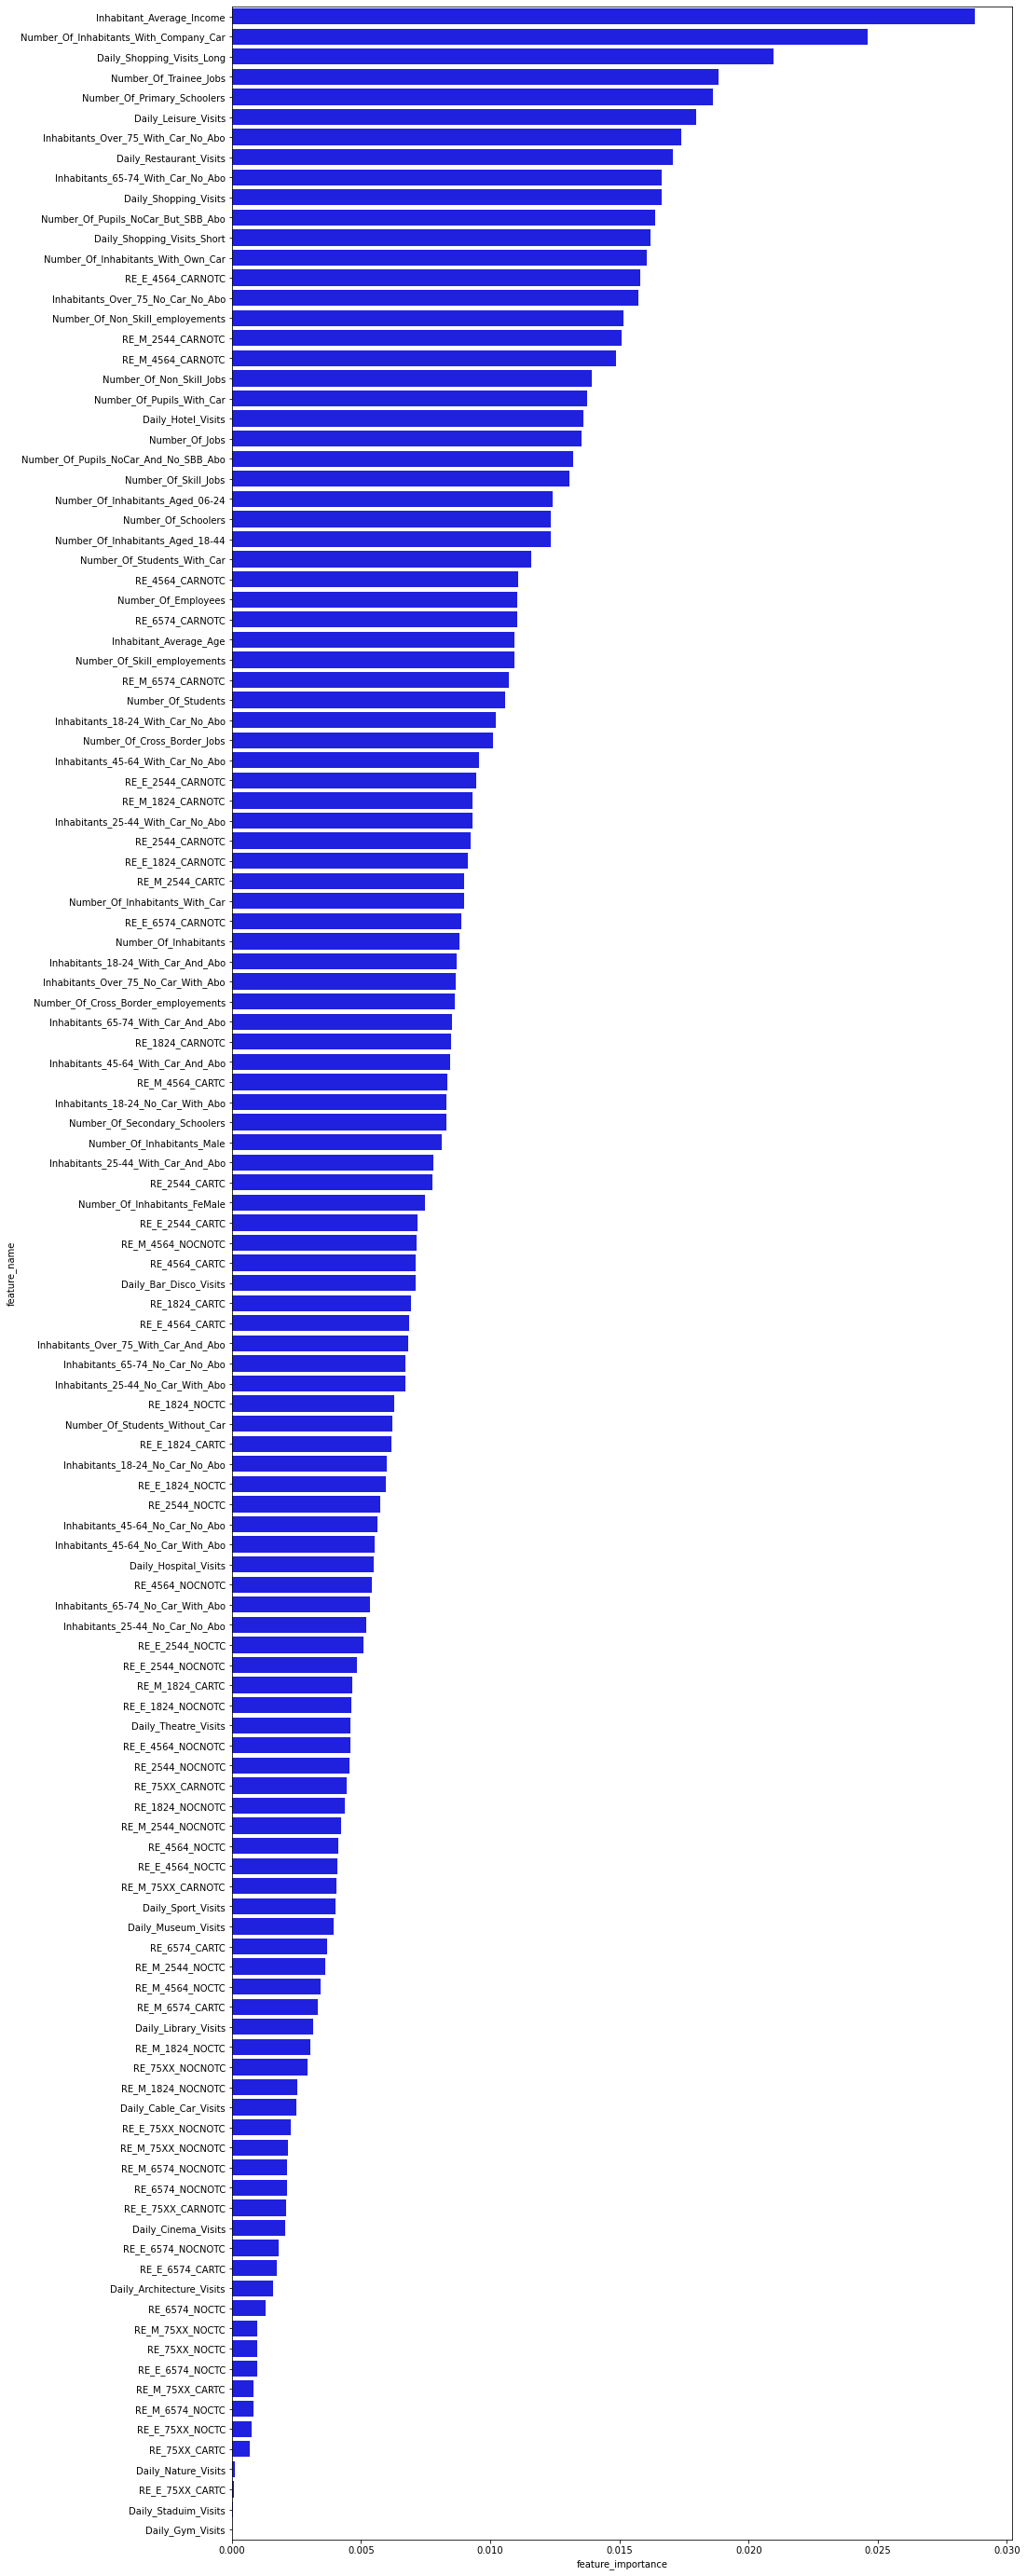

In [37]:
rf_feature_importance = forest_full_reg.feature_importances_
feature_importance_plot(rf_feature_importance, full_num_features)


In [38]:
reduced_num_features = ['Inhabitant_Average_Income', 'Number_Of_Inhabitants_With_Company_Car', 'Number_Of_Trainee_Jobs',
                        'Daily_Shopping_Visits', 'Number_Of_Primary_Schoolers', 'Daily_Shopping_Visits_Long',
                        'Daily_Leisure_Visits', 'Daily_Restaurant_Visits','Number_Of_Inhabitants_With_Own_Car',
                       'Number_Of_Pupils_NoCar_But_SBB_Abo','Daily_Shopping_Visits_Short','Number_Of_Skill_Jobs',
                       'Number_Of_Pupils_NoCar_And_No_SBB_Abo','Number_Of_Non_Skill_employements','Number_Of_Jobs',
                       'Inhabitant_Average_Age','Daily_Hotel_Visits','Number_Of_Inhabitants_Aged_06-24','Number_Of_Students',
                       'Number_Of_Employees','Number_Of_Inhabitants']

In [39]:
reduced_features_train_x = train_x[reduced_num_features]

In [40]:
reduced_features_train_x

,Inhabitant_Average_Income,Number_Of_Inhabitants_With_Company_Car,Number_Of_Trainee_Jobs,Daily_Shopping_Visits,Number_Of_Primary_Schoolers,Daily_Shopping_Visits_Long,Daily_Leisure_Visits,Daily_Restaurant_Visits,Number_Of_Inhabitants_With_Own_Car,Number_Of_Pupils_NoCar_But_SBB_Abo,...,Number_Of_Skill_Jobs,Number_Of_Pupils_NoCar_And_No_SBB_Abo,Number_Of_Non_Skill_employements,Number_Of_Jobs,Inhabitant_Average_Age,Daily_Hotel_Visits,Number_Of_Inhabitants_Aged_06-24,Number_Of_Students,Number_Of_Employees,Number_Of_Inhabitants
1099,82028,243,9,103,318,28,3,0,757,22,...,116,298,99,266,41,0,500,81,1151,2416
1025,80812,85,16,249,8,208,347,347,230,29,...,259,71,346,699,36,0,207,95,736,1198
726,89229,67,24,13,54,13,1,0,484,29,...,115,48,157,362,46,1,141,21,515,921
4885,91309,9,13,806,0,259,32,32,97,1,...,448,14,913,1863,41,0,31,4,114,190
3739,58645,140,65,15965,0,10901,2143,1654,433,11,...,669,112,698,1748,40,111,246,65,618,1502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,79005,362,115,599,230,93,59,14,745,14,...,319,201,431,952,38,45,365,37,768,1450
978,74134,223,31,462,14,446,363,362,576,51,...,253,109,187,576,39,0,301,230,1474,2543
7075,59704,5,4,3897,0,2497,182,106,74,5,...,391,3,201,1567,53,0,18,1,53,131
1258,95562,32,19,998,99,399,354,306,803,16,...,261,130,131,471,44,10,245,32,945,1438


In [41]:
forest_reduced_features_reg, forest_reduced_features_rmse = train_model(reduced_features_train_x, train_y, RandomForestRegressor(random_state=0))

In [42]:
print ("Random forest with reduced number of features RMSE: " + str(forest_reduced_features_rmse))

Random forest with reduced number of features RMSE: 137.42355250901733


### Feature selection

If one looks at the important features, one may see following patters

1. Infrastructure features such as vistis to muesuem indicating presence of Museums, of vistis for shopping suggesting presense of shopping malls etc., are important in determining subscription sale.
2. Ease of mobility information such as presence or absence of car or number of daily commuters are also corelated to SBB subscriptions
3. Demographic information such as number of inhabitants, income etc is also imporant for SBB subscription

Thus looking at patterns, three aspects for pridicting SBB sales are deemed significant

- Infrastructural elements 
- Accessibility and commute
- Demographics

Lets construct a data frame which has these 3 aspects

In [43]:
full_related_features = ['Number_Of_Inhabitants', 'Inhabitant_Average_Age', 'Number_Of_Inhabitants_Male',
                     'Number_Of_Inhabitants_FeMale', 'Inhabitant_Average_Income', 
                     'Number_Of_Inhabitants_With_Car', 'Number_Of_Employees','Number_Of_Jobs', 
                     'Number_Of_Skill_Jobs', 'Number_Of_Skill_employements', 'Number_Of_Non_Skill_Jobs',
                     'Number_Of_Trainee_Jobs', 'Number_Of_Non_Skill_employements', 'Number_Of_Schoolers',
                     'Number_Of_Primary_Schoolers', 'Number_Of_Secondary_Schoolers','Number_Of_Pupils_With_Car',
                     'Number_Of_Students_With_Car','Number_Of_Students_Without_Car',
                     'Daily_Shopping_Visits','Daily_Staduim_Visits','Daily_Nature_Visits',
                     'Daily_Theatre_Visits','Daily_Cinema_Visits','Daily_Library_Visits','Daily_Museum_Visits',
                     'Daily_Architecture_Visits','Daily_Sport_Visits','Daily_Gym_Visits','Daily_Restaurant_Visits',
                     'Daily_Bar_Disco_Visits','Daily_Hotel_Visits','Daily_Hospital_Visits','Daily_Cable_Car_Visits',
                     'Daily_Leisure_Visits'            
                    ]

In [44]:
df_X = X[full_related_features]
df_Y = Y

In [45]:
df_X['Has_Malls']           = df_X['Daily_Shopping_Visits'].astype(bool).astype(int)
df_X['Has_StaduimS']        = df_X['Daily_Staduim_Visits'].astype(bool).astype(int)
df_X['Has_Parks']           = df_X['Daily_Nature_Visits'].astype(bool).astype(int)
df_X['Has_Theaters']        = df_X['Daily_Theatre_Visits'].astype(bool).astype(int)
df_X['Has_Cinemas']         = df_X['Daily_Cinema_Visits'].astype(bool).astype(int)
df_X['Has_Libraries']       = df_X['Daily_Library_Visits'].astype(bool).astype(int)
df_X['Has_Museums']         = df_X['Daily_Museum_Visits'].astype(bool).astype(int)
df_X['Has_Architecture']    = df_X['Daily_Architecture_Visits'].astype(bool).astype(int)
df_X['Has_Sports']          = df_X['Daily_Sport_Visits'].astype(bool).astype(int)
df_X['Has_Gyms']            = df_X['Daily_Gym_Visits'].astype(bool).astype(int)
df_X['Has_Restaurants']     = df_X['Daily_Restaurant_Visits'].astype(bool).astype(int)
df_X['Has_Discos']          = df_X['Daily_Bar_Disco_Visits'].astype(bool).astype(int)
df_X['Has_Hotels']          = df_X['Daily_Hotel_Visits'].astype(bool).astype(int)
df_X['Has_Hospitals']       = df_X['Daily_Hospital_Visits'].astype(bool).astype(int)
df_X['Has_Cableway']        = df_X['Daily_Cable_Car_Visits'].astype(bool).astype(int)
df_X['Has_Liesure']         = df_X['Daily_Leisure_Visits'].astype(bool).astype(int)

<ipython-input-45-003800c3b237>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X['Has_Malls']           = df_X['Daily_Shopping_Visits'].astype(bool).astype(int)
<ipython-input-45-003800c3b237>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X['Has_StaduimS']        = df_X['Daily_Staduim_Visits'].astype(bool).astype(int)
<ipython-input-45-003800c3b237>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [46]:
cols_to_drop = ['Daily_Shopping_Visits','Daily_Staduim_Visits','Daily_Nature_Visits',
                     'Daily_Theatre_Visits','Daily_Cinema_Visits','Daily_Library_Visits','Daily_Museum_Visits',
                     'Daily_Architecture_Visits','Daily_Sport_Visits','Daily_Gym_Visits','Daily_Restaurant_Visits',
                     'Daily_Bar_Disco_Visits','Daily_Hotel_Visits','Daily_Hospital_Visits','Daily_Cable_Car_Visits',
                     'Daily_Leisure_Visits'            
                    ]

df_X = df_X.drop(cols_to_drop, axis=1)

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

train_scaler = StandardScaler()
df_X = train_scaler.fit_transform(df_X)

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2)

In [63]:
from tensorflow import keras

def coeff_determination(y_true, y_pred):
    SS_res =  keras.backend.sum(keras.backend.square( y_true-y_pred ))
    SS_tot = keras.backend.sum(keras.backend.square( y_true - keras.backend.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + keras.backend.epsilon()) )

In [64]:
#trying simple neural network
dim = X_train.shape[1]
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(dim),
  tf.keras.layers.Dense(int(dim*4), activation='relu'),
  tf.keras.layers.Dense(int(dim*2), activation='relu'),
  tf.keras.layers.Dense(int(dim/2), activation='relu'),
   tf.keras.layers.Dense(1, activation='relu')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # optimizer='adam',
              loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError(), coeff_determination])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 140)               5040      
_________________________________________________________________
dense_9 (Dense)              (None, 70)                9870      
_________________________________________________________________
dense_10 (Dense)             (None, 17)                1207      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 18        
Total params: 16,135
Trainable params: 16,135
Non-trainable params: 0
_________________________________________________________________


In [65]:
save_path = 'save/nn1_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

In [66]:
hist = model.fit(x=X_train, y=Y_train,
                 epochs=100, batch_size=32, 
                 validation_data=(X_test, Y_test),
                 callbacks=[save_callback])

Epoch 1/100
194/194 [==============================] - 1s 3ms/step - loss: 232499.1719 - root_mean_squared_error: 482.1817 - coeff_determination: -0.9734 - val_loss: 65734.5078 - val_root_mean_squared_error: 256.3874 - val_coeff_determination: 0.4223
Epoch 2/100
194/194 [==============================] - 0s 2ms/step - loss: 60163.1719 - root_mean_squared_error: 245.2818 - coeff_determination: 0.4646 - val_loss: 47681.9375 - val_root_mean_squared_error: 218.3619 - val_coeff_determination: 0.5847
Epoch 3/100
194/194 [==============================] - 0s 2ms/step - loss: 47621.3984 - root_mean_squared_error: 218.2233 - coeff_determination: 0.5695 - val_loss: 41065.9180 - val_root_mean_squared_error: 202.6473 - val_coeff_determination: 0.6439
Epoch 4/100
194/194 [==============================] - 0s 2ms/step - loss: 42167.7227 - root_mean_squared_error: 205.3478 - coeff_determination: 0.6283 - val_loss: 39296.7227 - val_root_mean_squared_error: 198.2340 - val_coeff_determination: 0.6644
Ep

Epoch 34/100
194/194 [==============================] - 0s 2ms/step - loss: 24554.9238 - root_mean_squared_error: 156.7001 - coeff_determination: 0.7890 - val_loss: 29605.2949 - val_root_mean_squared_error: 172.0619 - val_coeff_determination: 0.7464
Epoch 35/100
194/194 [==============================] - 0s 2ms/step - loss: 24271.0410 - root_mean_squared_error: 155.7917 - coeff_determination: 0.7866 - val_loss: 29615.6152 - val_root_mean_squared_error: 172.0919 - val_coeff_determination: 0.7466
Epoch 36/100
194/194 [==============================] - 0s 2ms/step - loss: 24063.8320 - root_mean_squared_error: 155.1252 - coeff_determination: 0.7844 - val_loss: 29616.1504 - val_root_mean_squared_error: 172.0934 - val_coeff_determination: 0.7459
Epoch 37/100
194/194 [==============================] - 0s 2ms/step - loss: 23980.9199 - root_mean_squared_error: 154.8577 - coeff_determination: 0.7900 - val_loss: 29427.2969 - val_root_mean_squared_error: 171.5439 - val_coeff_determination: 0.7479


Epoch 67/100
194/194 [==============================] - 0s 2ms/step - loss: 18998.9023 - root_mean_squared_error: 137.8365 - coeff_determination: 0.8336 - val_loss: 30289.0059 - val_root_mean_squared_error: 174.0374 - val_coeff_determination: 0.7413
Epoch 68/100
194/194 [==============================] - 0s 2ms/step - loss: 19220.7227 - root_mean_squared_error: 138.6388 - coeff_determination: 0.8294 - val_loss: 28872.7344 - val_root_mean_squared_error: 169.9198 - val_coeff_determination: 0.7501
Epoch 69/100
194/194 [==============================] - 0s 2ms/step - loss: 18999.4355 - root_mean_squared_error: 137.8384 - coeff_determination: 0.8314 - val_loss: 29707.1016 - val_root_mean_squared_error: 172.3575 - val_coeff_determination: 0.7435
Epoch 70/100
194/194 [==============================] - 0s 2ms/step - loss: 18684.5996 - root_mean_squared_error: 136.6916 - coeff_determination: 0.8317 - val_loss: 28691.8691 - val_root_mean_squared_error: 169.3867 - val_coeff_determination: 0.7517


Epoch 100/100
194/194 [==============================] - 0s 2ms/step - loss: 15836.3555 - root_mean_squared_error: 125.8426 - coeff_determination: 0.8602 - val_loss: 30336.8066 - val_root_mean_squared_error: 174.1746 - val_coeff_determination: 0.7398


In [47]:
# Train RMSE
hist.history['root_mean_squared_error'][-1]

131.3206024169922

In [48]:
# Validation RMSE
hist.history['val_root_mean_squared_error'][-1]

169.20054626464844

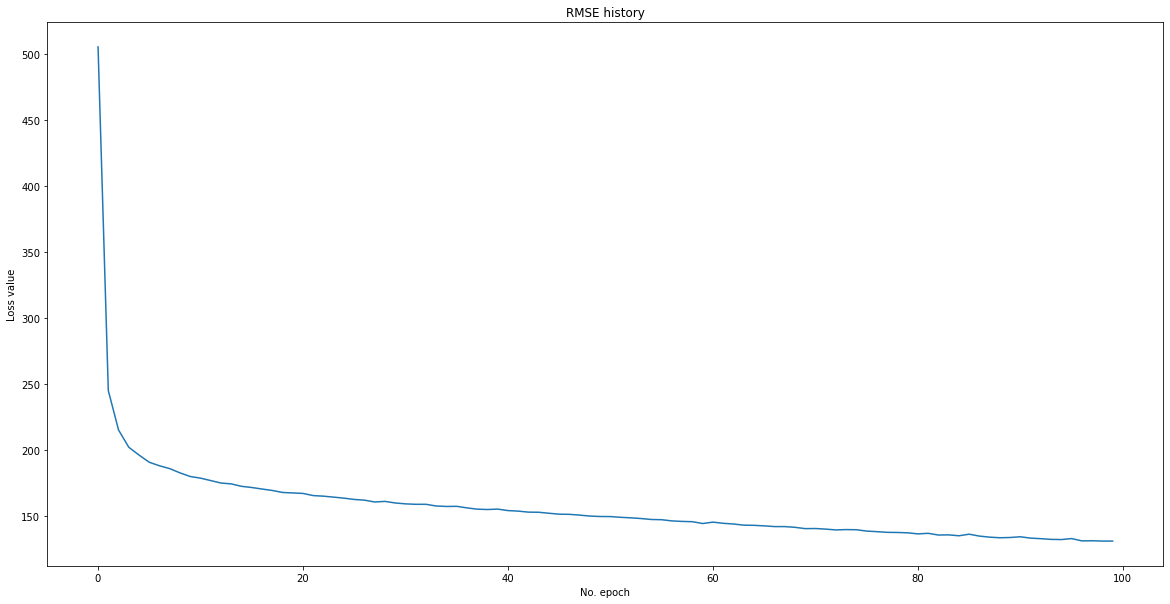

In [49]:
# Visualize history
# Plot history: Loss
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(hist.history['root_mean_squared_error'])
plt.title('RMSE history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

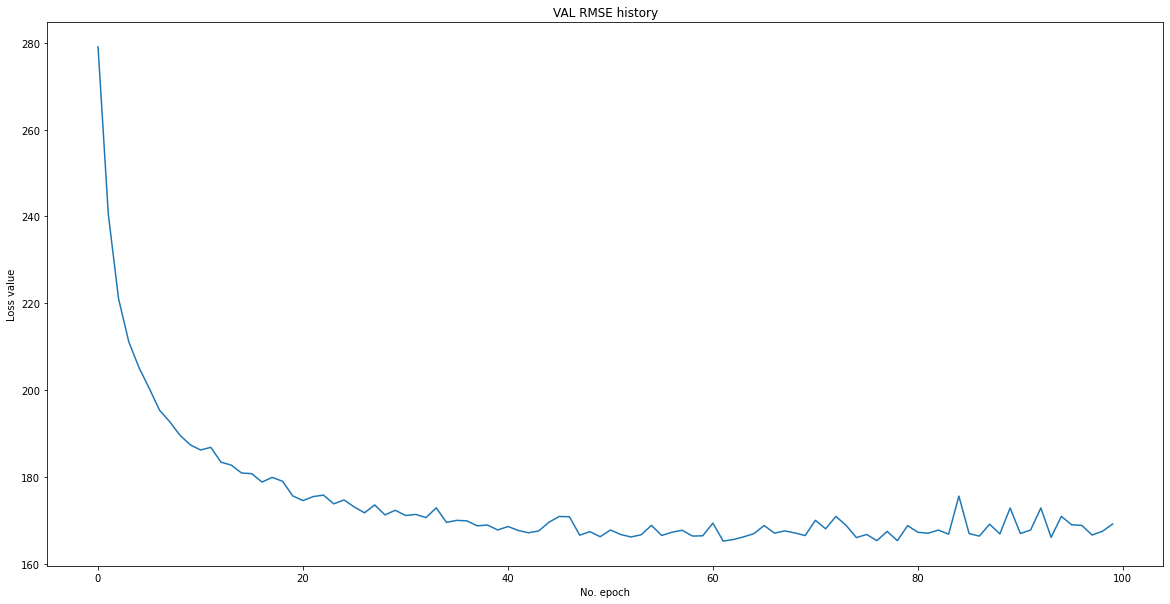

In [50]:
# Visualize history
# Plot history: Loss
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('VAL RMSE history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

In [67]:
# Validation RMSE
hist.history['val_coeff_determination'][-1]

0.7397565841674805